In [ ]:
520 Assignment 1 - Fast Trajectory Replanning:
    Suraj.K.A - skk140
    Deepak Vagish K - dk1156
    Shirisha Sudhakar Rao - ss4313

In [1]:
import math
import numpy as np
import random
from random import choices
from typing import TypeVar,List
from sortedcontainers import SortedSet
import numpy as np
import matplotlib.pyplot as plt
import collections
import time
from colorama import init, Fore

In [2]:
def heapify(x):
    for i in range(int(len(x)/2) - 1, -1, -1):
        insert_up(x, i)

def insert_up(heap, pos):
    end_ind = len(heap)
    start_ind = pos
    new_item = heap[pos]

    child_ind = 2 * pos + 1
    while child_ind < end_ind:
        right_ind = child_ind + 1
        
        if right_ind < end_ind and heap[child_ind] > heap[right_ind]:
            child_ind = right_ind

        heap[pos] = heap[child_ind]
        pos = child_ind
        child_ind = 2 * pos + 1

    heap[pos] = new_item
    insert_down(heap, start_ind, pos)

def insert_down(heap, start_ind, current_ind):
    current_item = heap[current_ind]
    while current_ind > start_ind:
        parent_ind = (current_ind - 1) >> 1
        parent = heap[parent_ind]
        if current_item < parent:
            heap[current_ind] = parent
            current_ind = parent_ind
        else:
            break
    heap[current_ind] = current_item
    
def heappush(heap, item):
    heap.append(item)
    insert_down(heap, 0, len(heap)-1)

def heappop(heap):
    lastelt = heap.pop()    
    if heap:
        returnitem = heap[0]
        heap[0] = lastelt
        insert_up(heap, 0)
        return returnitem
    return lastelt

In [4]:
#The cell class is used to store the data about each individual state on the grid
#It takes the state's co-ordinates as parameters
class cell:
    def __init__(self,x,y):
        self.x = x         #x coordinate of the state
        self.y = y         #y coordinate of the state
        self.b = False     #Indicates if the state is blocked
        self.g = 0         #Distance from the start state to the current state
        self.f = 0         #Cost function
        self.h = 0         #h value of the state
        self.p = 0         #Indicates if the state is a part of the final path
    def __lt__(self, other: cell) -> bool:   #Used by the heap library to compare g values
        if((self.f) != (other.f)):
            return (self.f) < (other.f)
        else:
            return self.g > other.g
    def set_hval(self,t_x,t_y):    #Calculate the manhattan distance and cost
        self.h = abs(t_x - self.x) + abs(t_y - self.y)
        self.f = self.g + self.h
    def set_fvalAdap(self):        #Calculate f value for adaptive A*
        self.f = self.h + self.g

In [5]:
#The class represents the gridworld
class maze:
    def __init__(self,rows,columns,sx,sy,tx,ty,probability):
        self.rows = rows           #Number of rows in the grid
        self.columns = columns     #Number of columns in the grid
        self.sx = sx               #x coordinate of start state
        self.sy = sy               #y coordinate of start state
        self.tx = tx               #x coordinate of goal state
        self.ty = ty               #y coordinate of goal state
        self.visited = [[False for i in range(self.rows)] for j in range(self.columns)] #To mark visisted states in DFS
        self.options = ['b','u']   #Blocked and unblocked
        self.weights = [probability,1-probability]    #To generate blocked states
        self.drow = [0, 1, 0, -1]
        self.dcol = [-1, 0, 1, 0]
        self.mz = []               #Actual maze
        for i in range(self.rows): #Initializing the maze to a list of empty cells
            arr = []
            for j in range(self.columns):
                c = cell(i,j)
                arr.append(c)      
            self.mz.append(arr)            
    def isValid(self,r,c):         #Checks if the state is within the boundaries of the gridworld
        if (r < 0 or c < 0 or r >= self.rows or c >= self.columns):
            return False
        if (self.visited[r][c]):
            return False
        return True
    def DFS(self,grid,sx,sy,tx,ty): #Used to traverse the nodes and mark cells as blocked and unblocked
        stk = []
        stk.append([sx, sy])
        while(len(stk)>0):
            curr = stk[len(stk) - 1]
            stk.remove(stk[len(stk) - 1])
            r = curr[0]
            c = curr[1]
            if(self.isValid(r, c) == False):
                continue
            p = choices(self.options,self.weights)
            self.visited[r][c] = True
            if((r!= sx or c != sy) and (r!=tx or c != ty)):
                if(p[0] == 'b'):
                    self.mz[r][c].b = True
            for i in range(4):
                adjx = r + self.drow[i]
                adjy = c + self.dcol[i]
                stk.append([adjx, adjy])
    


In [6]:
grid_worlds = []
for i in range(50):
    grid_world = maze(101,101,0,0,100,100,0.3)
    grid_world.DFS([],0,0,100,100)
    grid_worlds.append(grid_world)

In [7]:
def getPath(start_cell_ind,parent_dict,curr_cell):  #Returns the path computed by A*
    path = []
    curr = curr_cell
    while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
        path.append([curr.x, curr.y])
        curr = parent_dict[(curr.x, curr.y)]
    path.append([curr.x,curr.y])
    return path[::-1]

In [8]:
#Path finding algorithm
def Astar(grid,start_cell_ind,goal_cell_ind, weight = 1):
    cells_processed = 0 #Counter for expanded states
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] 
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] 
    drow = [0, 1, 0, -1]
    dcol = [-1, 0, 1, 0]
    open_list = list()   #Maintains list of unexplored states. Implemented using heapq
    close_list = set()   #Maintains list of explored states
    parent_dict = {}     #Holds parent child relationship between the states. Helps find the final path
    visited = set()      
    start_cell.g = 0 
    start_cell.set_hval(goal_cell_ind[0], goal_cell_ind[1])
    heappush(open_list,start_cell)  #Push start state to the binary heap 
    visited.add((start_cell.x, start_cell.y)) 
    while len(open_list)>0: 
        cl = heappop(open_list)
        curr_cell = grid[cl.x][cl.y]
        cells_processed += 1
        close_list.add((curr_cell.x, curr_cell.y)) 
        if curr_cell == goal_cell: 
            path = getPath(start_cell_ind,parent_dict,curr_cell)
            return path, cells_processed
        children = [] 
        for i in range(4):
            new_cell = (curr_cell.x+drow[i], curr_cell.y+dcol[i]) 
            if(new_cell[0] > len(grid)-1 or new_cell[1] > len(grid)-1 or new_cell[0] < 0 or new_cell[1] < 0 or grid[new_cell[0]][new_cell[1]].b or (new_cell[0], new_cell[1]) in close_list):
                continue
            if((new_cell[0], new_cell[1]) in visited):
                if curr_cell.g + 1 + grid[new_cell[0]][new_cell[1]].h < grid[new_cell[0]][new_cell[1]].f:
                    removalCell = grid[new_cell[0]][new_cell[1]]
                    open_list.remove(removalCell)
                    removalCell.g = curr_cell.g+1
                    removalCell.set_hval(goal_cell_ind[0], goal_cell_ind[1])
                    heappush(open_list,removalCell)                                
                    parent_dict[(new_cell[0],new_cell[1])] = curr_cell 
            else:
                grid[new_cell[0]][new_cell[1]].g = curr_cell.g + 1
                grid[new_cell[0]][new_cell[1]].set_hval(goal_cell_ind[0], goal_cell_ind[1])
                children.append(grid[new_cell[0]][new_cell[1]])
                parent_dict[(new_cell[0],new_cell[1])] = curr_cell
        if(children == []):
            continue
        for child in children: 
            heappush(open_list,child)                                        
            visited.add((child.x, child.y))
    return [], 0

In [9]:
from matplotlib.colors import ListedColormap
def display_maze(m,start_cell_ind, goal_cell_ind):
    sx = start_cell_ind[0]
    sy = start_cell_ind[1]
    tx = goal_cell_ind[0]
    ty = goal_cell_ind[1]
    l = []
    for i in range(101):
        a = []
        for j in range(101):
            if(i == sx and j == sy):
                a.append(2)
                #print(Fore.BLUE, f's', end="")
            elif(i == tx and j == ty):
                a.append(2)
                #print(Fore.BLUE, f't', end="")
            elif m[i][j].b:
                a.append(1)
                #print(i,j)
                #print(Fore.RED, f'x', end="")
            elif m[i][j].p:
                a.append(3)
            else:
                a.append(0)
                #print(Fore.GREEN, f'-', end="")
        l.append(a)
        
        #print('\n')
        #figsize = (20,10)
    #cmap = ListedColormap(["green", "red","blue","white"])
    
    plt.figure()
    plt.imshow(l, cmap='hot', interpolation='nearest')

In [10]:
def final_path(path,agent_env,real_mz,start_cell_ind, goal_cell_ind):
    drow = [0, 1, 0, -1]
    dcol = [-1, 0, 1, 0]
    for index in range(len(path)):
        x_ind = path[index][0]
        y_ind = path[index][1]
        agent_env[x_ind][y_ind].x = real_mz[x_ind][y_ind].x
        agent_env[x_ind][y_ind].y = real_mz[x_ind][y_ind].y
        agent_env[x_ind][y_ind].b = real_mz[x_ind][y_ind].b
        agent_env[x_ind][y_ind].p = 1
        #print(agent_env[x_ind][y_ind].f)
        if(real_mz[x_ind][y_ind].b):
            #display_maze(real_mz,start_cell_ind, goal_cell_ind)
            return path[:index]
        for new_cell in range(4):
            child_pos = (x_ind+drow[new_cell], y_ind+dcol[new_cell])
            if(child_pos[0] > len(real_mz)-1 or child_pos[1] > len(real_mz)-1 or child_pos[0] < 0 or child_pos[1] < 0):
                continue
            agent_env[child_pos[0]][child_pos[1]].x = real_mz[child_pos[0]][child_pos[1]].x
            agent_env[child_pos[0]][child_pos[1]].y = real_mz[child_pos[0]][child_pos[1]].y
            agent_env[child_pos[0]][child_pos[1]].b = real_mz[child_pos[0]][child_pos[1]].b
    #display_maze(real_mz,start_cell_ind, goal_cell_ind)
    #display_maze(agent_env,start_cell_ind, goal_cell_ind)
    return path

In [21]:
def computePath(agent_env,real_mz,start_cell_ind, goal_cell_ind):
    paths = []
    counter = 0
    x = 0
    while(1):
        counter += 1
        path,c = Astar(agent_env,start_cell_ind,goal_cell_ind)
        paths.append(path)
        x += c
        #print(pathA)
        if(path == []):
            print("I cannot reach the target")
            display_maze(agent_env,start_cell_ind,goal_cell_ind)
            print("cells processed")
            print(x)
            break
        else:
            #print(path)
            p = final_path(path,agent_env,real_mz,start_cell_ind, goal_cell_ind)
            if(p[-1] == goal_cell_ind):
                print("I reached the target")
                print("final")
                print("-------")
                display_maze(agent_env,start_cell_ind,goal_cell_ind)
                print("cells processed")
                print(x)
                return paths
            else:
                start_cell_ind = p[-1]
                if(counter%5 == 0):
                    display_maze(agent_env,start_cell_ind,goal_cell_ind)

In [25]:
def computePathBackwards(agent_env,real_mz,start_cell_ind, goal_cell_ind):
    paths = []
    counter = 0
    x = 0
    while(1):
        counter += 1
        #print(counter)
        path,c = Astar(agent_env,goal_cell_ind,start_cell_ind,)
        paths.append(path)
        x += c
        #print(pathA)
        if(path == []):
            print("I cannot reach the target")
            display_maze(agent_env,start_cell_ind,goal_cell_ind)
            print("cells processed")
            print(x)
            break
        else:
            #print(path[::-1])
            p = final_path(path[::-1],agent_env,real_mz, goal_cell_ind,start_cell_ind)
            if(p[-1] == goal_cell_ind):
                print("I reached the target")
                print("final")
                print("-------")
                display_maze(agent_env,start_cell_ind,goal_cell_ind)
                print("cells processed")
                print(x)
                return paths
            else:
                start_cell_ind = p[-1]
                if(counter%5 == 0):
                    display_maze(agent_env,start_cell_ind,goal_cell_ind)

I reached the target
final
-------
cells processed
10455
1.25642991065979


C:\Users\SURAJ\AppData\Local\Temp\ipykernel_10084\2826335026.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


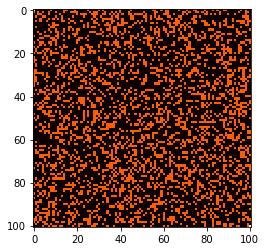

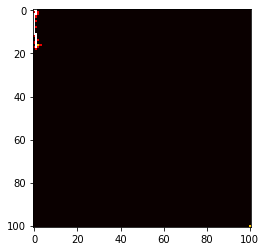

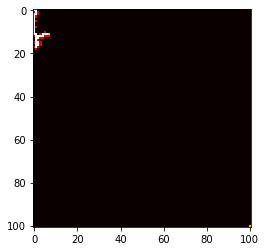

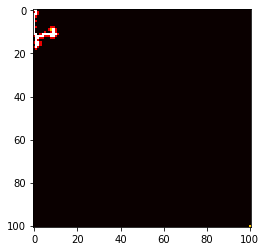

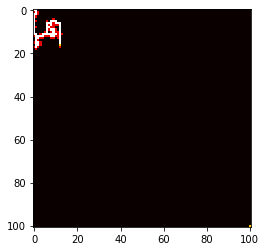

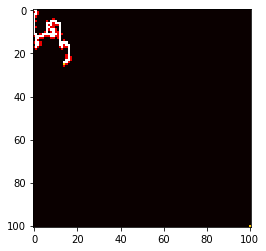

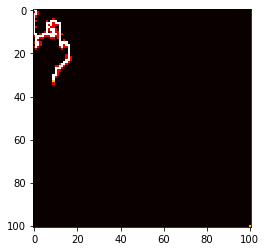

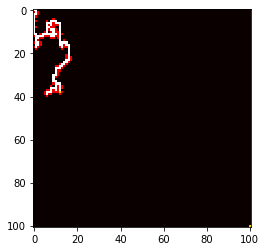

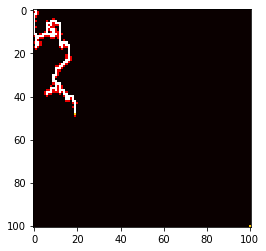

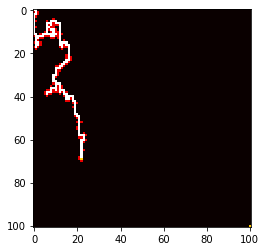

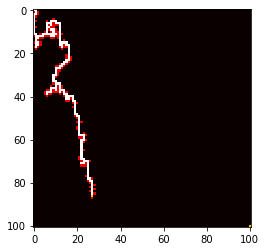

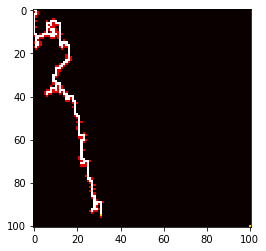

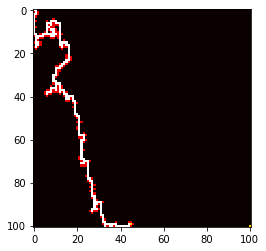

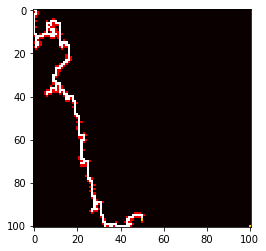

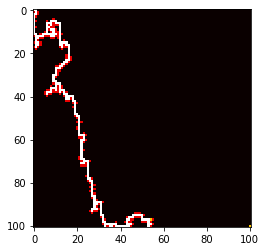

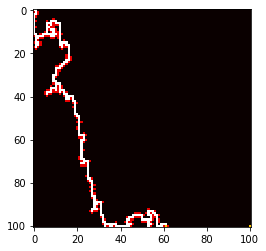

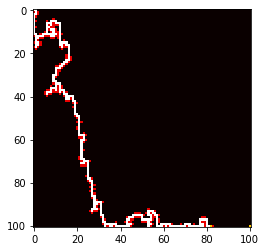

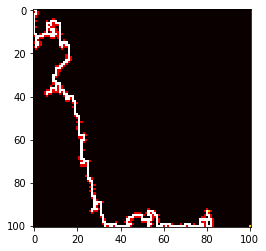

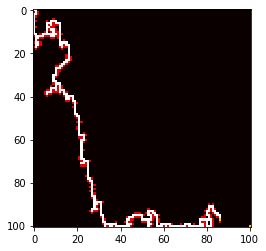

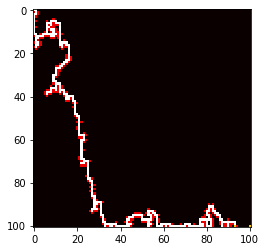

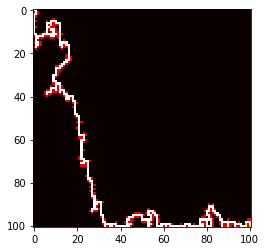

In [51]:
#forward A*
agent_env = maze(101,101,0,0,100,100,0)
agent_env.DFS([],0,0,100,100)
#display_maze(agent_env.mz,[0,0],[9,9])
display_maze(grid_worlds[17].mz,[0,0],[100,100])
start = time.time()
paths = computePath(agent_env.mz,grid_worlds[17].mz,[0,0],[100,100])
end = time.time()
print(end -start)
#print(paths)

C:\Users\SURAJ\AppData\Local\Temp\ipykernel_10084\2826335026.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


I reached the target
final
-------
cells processed
239108
18.213090419769287


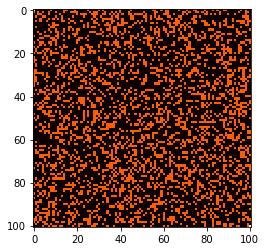

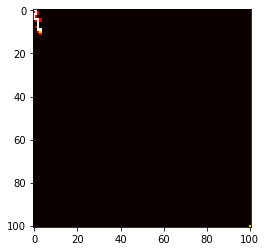

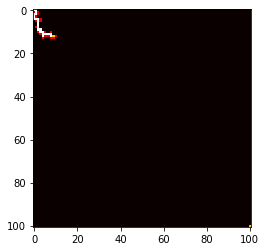

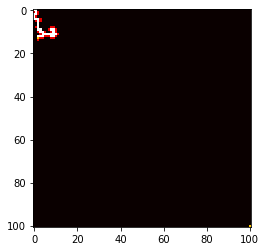

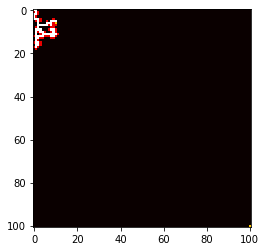

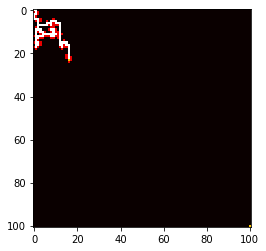

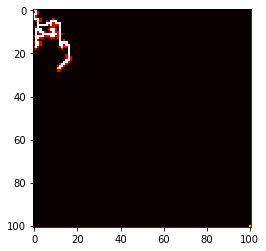

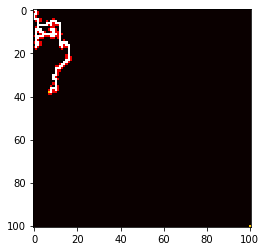

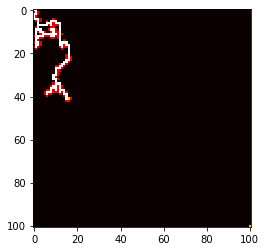

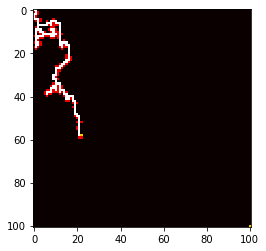

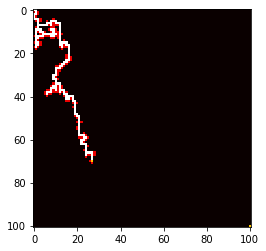

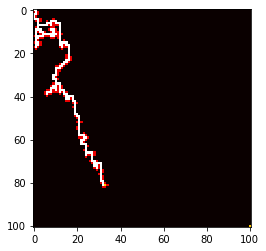

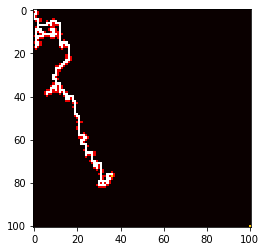

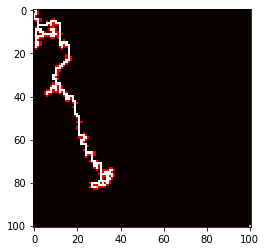

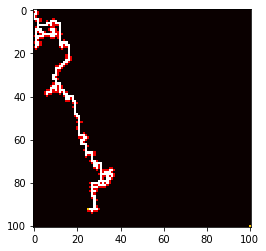

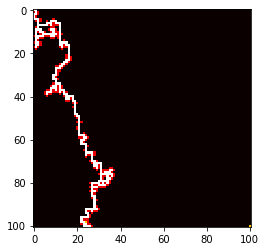

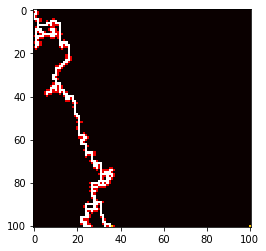

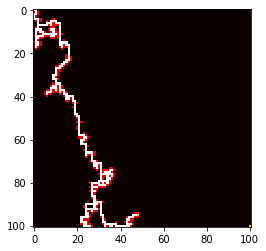

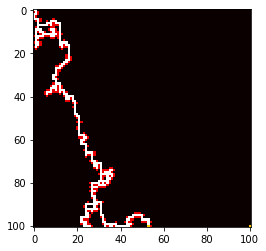

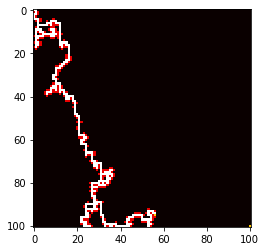

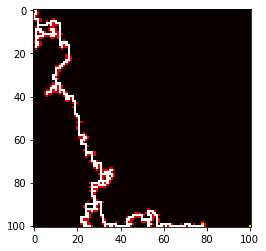

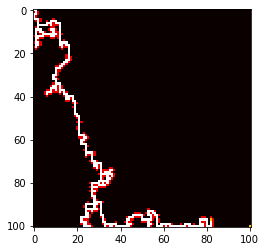

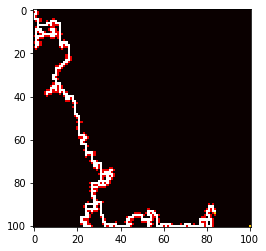

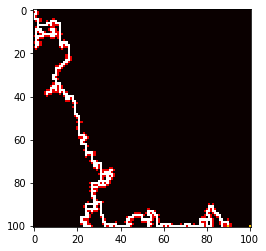

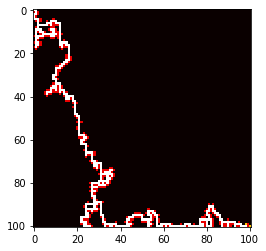

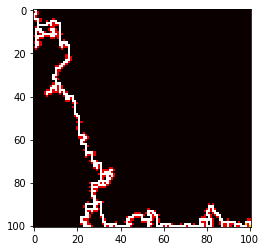

In [52]:
#backward A*
agent_env = maze(101,101,0,0,100,100,0)
agent_env.DFS([],0,0,100,100)
#display_maze(agent_env.mz,[0,0],[9,9])
display_maze(grid_worlds[17].mz,[0,0],[100,100])
start = time.time()
paths = computePathBackwards(agent_env.mz,grid_worlds[17].mz,[0,0],[100,100])
end = time.time()
print(end -start)
#print(paths)

In [35]:
#Get path from current state to start state
def getPathAdap(start_cell_ind,parent_dict,curr_cell,grid): 
    path = []
    curr = curr_cell
    gs = grid[curr.x][curr.y].g
    while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
        path.append([curr.x, curr.y])
        curr = parent_dict[(curr.x, curr.y)]
    path.append([curr.x,curr.y])
    return path[::-1],gs

In [38]:
#Path finding algorithm with heurstic value updates after each iteration
def AdaptiveAstar(grid,start_cell_ind,goal_cell_ind, weight = 1):
    cells_processed = 0   #Counter for expanded states
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] 
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] 
    drow = [0, 1, 0, -1]
    dcol = [-1, 0, 1, 0]
    open_list = list()    #Maintains list of unexplored states. Implemented using heapq
    close_list = set()    #Maintains list of explored states
    parent_dict = {}      #Holds parent child relationship between the states. Helps find the final path
    visited = set()       #Contains a set of visited child states
    start_cell.g = 0      #g value of start node is 0
    start_cell.set_fvalAdap()  #Calculate f value
    heappush(open_list,start_cell)  #Pushing the start state to open list
    
    visited.add((start_cell.x, start_cell.y)) #Adding the start cell to visited nodes
    
    while len(open_list)>0: #Loop priority queue until either all states are visited or we have reached the goal state
        cl = heappop(open_list)  #Getting the state with smallest cost
        curr_cell = grid[cl.x][cl.y]   #storing the state popped
        cells_processed += 1           
        close_list.add((curr_cell.x, curr_cell.y)) #Adding the state to the closed list
        #If the state popped is the goal state, return the path using the parent dictionary and all the states processed
        if curr_cell == goal_cell:  
            path, gs = getPathAdap(start_cell_ind,parent_dict,curr_cell,grid)
            #Calculating hnew for the state
            for val in close_list:
                grid[val[0]][val[1]].h = gs - grid[val[0]][val[1]].g
            return path, cells_processed
        children = [] #Keep a track of all states reachable from current state
        for i in range(4): 
            new_cell = (curr_cell.x+drow[i], curr_cell.y+dcol[i]) #Can move only in 4 main compass directions 
            #new state not in bounds or is blocked or is already in closed_list, continue
            if(new_cell[0] > len(grid)-1 or new_cell[1] > len(grid)-1 or new_cell[0] < 0 or new_cell[1] < 0 or grid[new_cell[0]][new_cell[1]].b or (new_cell[0], new_cell[1]) in close_list):
                continue 
            if((new_cell[0], new_cell[1]) in visited): #State alreay visited, compare previous cost to new cost
                #Remove state and reinsert with based on the new priority due to updated hnew
                if curr_cell.g + 1 + grid[new_cell[0]][new_cell[1]].h < grid[new_cell[0]][new_cell[1]].f:
                    removalCell = grid[new_cell[0]][new_cell[1]]
                    open_list.remove(removalCell)
                    removalCell.g = curr_cell.g+1
                    removalCell.set_fvalAdap()
                    heappush(open_list,removalCell)                                
                    parent_dict[(new_cell[0],new_cell[1])] = curr_cell 
            else:
                #Child not visited, update the g,f and h values
                grid[new_cell[0]][new_cell[1]].g = curr_cell.g + 1
                grid[new_cell[0]][new_cell[1]].set_fvalAdap()
                children.append(grid[new_cell[0]][new_cell[1]])
                parent_dict[(new_cell[0],new_cell[1])] = curr_cell
        if(children == []): 
            continue
        for child in children: 
            heappush(open_list,child)  #Add children to open_list                                      
            visited.add((child.x, child.y))
    return [], 0

In [33]:
def computePath_AdaptiveAstar(agent_env,real_mz,start_cell_ind, goal_cell_ind):
    paths = []
    counter = 0
    x = 0
    while(1):
        counter += 1
        path,c = AdaptiveAstar(agent_env,start_cell_ind,goal_cell_ind)
        x += c
        paths.append(path)
        if(path == []):
            print("I cannot reach the target")
            print("cells processed")
            print(x)
            break
        else:
            p = final_path(path,agent_env,real_mz,start_cell_ind, goal_cell_ind)
            if(p[-1] == goal_cell_ind):
                print("I reached the target")
                print("final")
                display_maze(agent_env,start_cell_ind,goal_cell_ind)
                print("cells processed")
                print(x)
                return paths
            else:
                start_cell_ind = p[-1]
                if(counter%5 == 0):
                    display_maze(agent_env,start_cell_ind,goal_cell_ind)

C:\Users\SURAJ\AppData\Local\Temp\ipykernel_10084\2826335026.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


I reached the target
final
cells processed
21441
1.7195091247558594


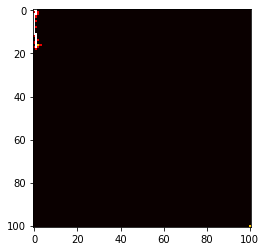

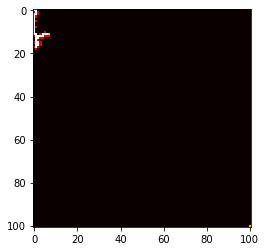

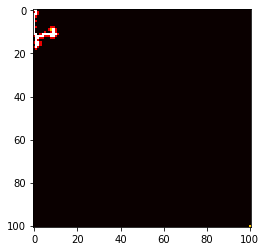

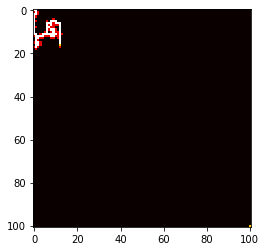

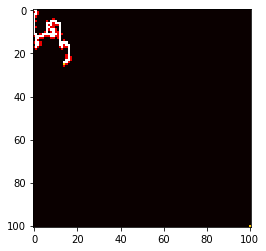

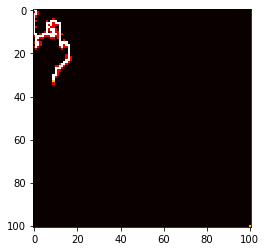

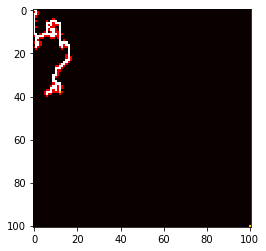

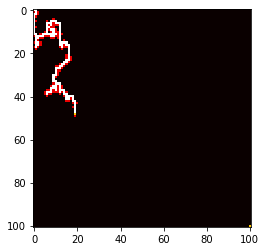

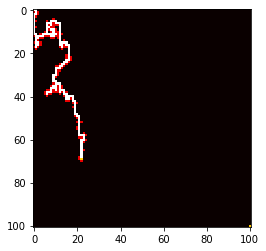

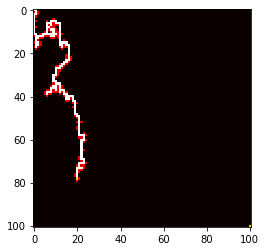

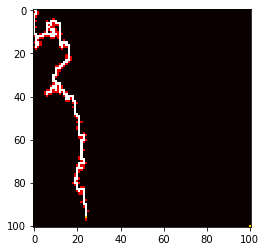

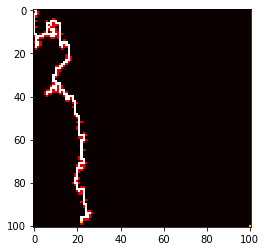

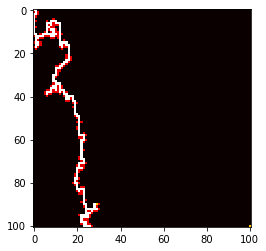

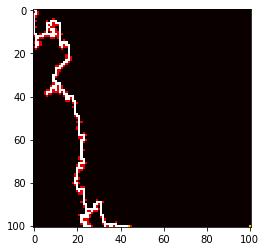

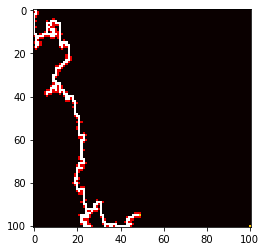

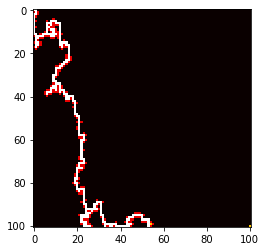

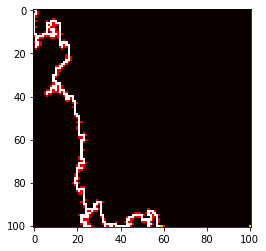

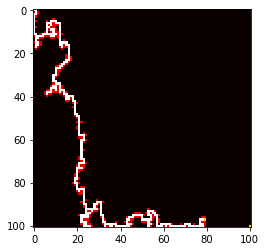

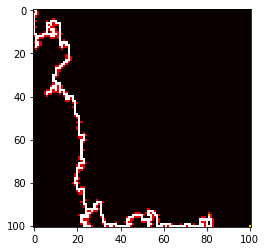

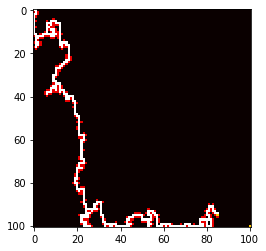

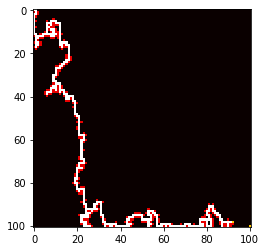

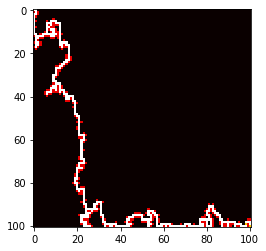

In [53]:
Adagent_env = maze(101,101,0,0,100,100,0)
Adagent_env.DFS([],0,0,100,100)
#display_maze(grid_worlds[32].mz,[0,0],[100,100])
start = time.time()
path = computePath_AdaptiveAstar(Adagent_env.mz,grid_worlds[17].mz,[0,0],[100,100])
end = time.time()
print(end - start)
#print(path)